In [101]:
import os
from pathlib import Path
import tensorflow as tf
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import VariationalAutoencoder as VAE
import DesignGenerator as DG
import utils

# from imgaug import augmenters
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# matplotlib.use('Agg')
plt.gray()
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [170]:
#Import trained variational autoencoder form the database
vae_db = tf.saved_model.load('saved/vae2.h5')
encoder_db = vae_db.encoder
decoder_db = vae_db.decoder
regressor_db = vae_db.regressor
decoder_bitstring = tf.keras.models.load_model('saved\encoder_bitstring.h5')
# regressor_db.compile(optimizer=keras.optimizers.Adam())

design_gen = DG.DesignGenerator(encoder_db, decoder_db, regressor_db, decoder_bitstring)

In [180]:
#Import data
df = pd.read_csv("saved/metamaterial_designs.csv")
df = df.fillna(method='ffill')
#Designs
X = df['image'].values
X = np.array([json.loads(x) for x in X])
# Number of lines
lines = np.array([sum(json.loads(df['design_bitstring'][i])) for i in range(df.shape[0])])
#Attributes
Y = df[['vertical_lines', 'horizontal_lines', 'diagonals', 'triangles', 'three_stars']].values
# Y = Y/lines[:,None]
means = np.mean(Y, axis=0, keepdims=True)
stds = np.std(Y, axis=0, keepdims=True)
Y = (Y-means)/stds
#Objectives
F = df[['obj1', 'obj2', 'constr1']].values

(array([2455., 4501., 5990., 5359., 3859.,    0., 1327.,  603.,   38.,
          12.]),
 array([-1.62804174, -1.0915038 , -0.55496587, -0.01842794,  0.51811   ,
         1.05464793,  1.59118587,  2.1277238 ,  2.66426173,  3.20079967,
         3.7373376 ]),
 <a list of 10 Patch objects>)

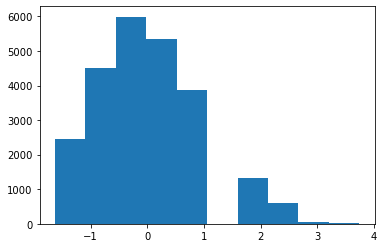

In [184]:
plt.hist(Y[:,4])

### Sanity Check

Text(0.5, 1.0, 'Reconstructed')

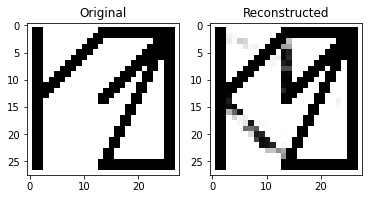

In [130]:
i = 126
x = X[i].reshape(-1,28,28,1)
y = Y[i][None,:]
f = F[i][None,:]
cond_dim = y.shape[1]
n_sample = x.shape[0]
fig, ax = plt.subplots(1,2)
#Encoder
y_ = y.reshape(-1,1,1,cond_dim)
k = tf.ones([n_sample, 28, 28, 1])
x_input = tf.concat([x, k*y_], 3)
ax[0].imshow(1-x.squeeze())
ax[0].set_title('Original')
z_mu, z_log_sigma, z = encoder_db(x_input)
#Decoder
h = tf.concat([z, y], 1)
x_reconstructed = decoder_db(h)
ax[1].imshow(1-tf.squeeze(x_reconstructed))
ax[1].set_title('Reconstructed')

## 1. Driving features in given images

Input images:


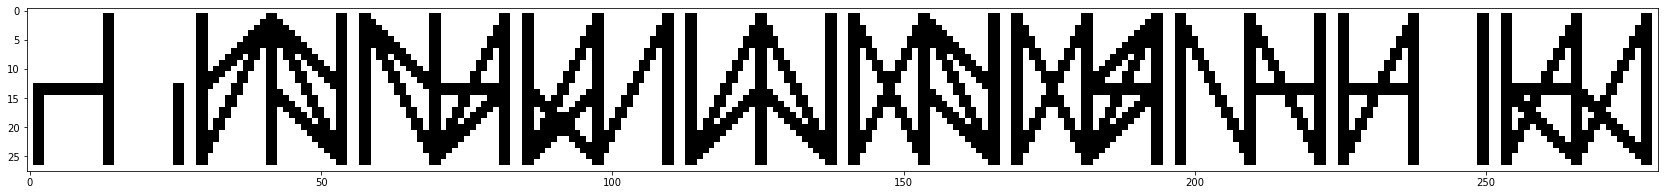

Identified features:


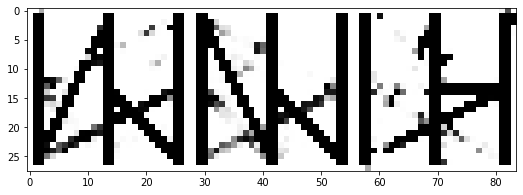

In [131]:
n_img = 15
# idx_images = np.random.choice(range(X.shape[0]), n_img)
idx1 = utils.is_pareto_efficient(F[:,0:2]*np.array([-1,1]))
images = X[idx1,:].squeeze()
attributes = Y[idx_images,:]
reconstr_images = design_gen.get_driving_features(images, attributes, K=3)

print("Input images:")
idx2 = np.random.randint(sum(idx1), size=10)
utils.plot_1Dgrid_images(images[idx2].squeeze())
print("Identified features:")
utils.plot_1Dgrid_images(reconstr_images.squeeze())

## 2. Edit given image 

In [185]:
# Edit an image
idx = np.random.choice(range(X.shape[0]), 1)
image = X[idx,:].squeeze()
attributes = Y[idx,:].squeeze()

### Feature space exploration

In [186]:
attribute_names = ['horizontal_lines', 'vertical_lines', 'diagonals', 'triangles', 'three_stars']
objectives = ['Verical Stiffness', 'Volume Fraction', 'Feasibility']
scale=2.5
step=0.1
image_size=28

attr_sliders = list()
for name in attribute_names:
    attr_sliders.append(widgets.FloatSlider(
        value=0,
        min=-scale,
        max=scale,
        step=step,
        description=name,
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
    ))

kwargs = {attribute_names[i]:slider for i, slider in enumerate(attr_sliders)}
def plot_superposition_attributes(_image, _attr, **kwargs):
    _reconstr_image = design_gen.superposition_attributes(_image, _attr, **kwargs)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(1-image.squeeze())
    ax[0].set_title('Original')
    ax[1].imshow(1-np.squeeze(_reconstr_image))
    ax[1].set_title('Reconstructed')
    
f = interact(plot_superposition_attributes, 
            _image=fixed(image), 
            _attr=fixed(attributes), **kwargs)


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='horizontal_lines', max=2.5,…

### Augmented feature space exploration

In [187]:
ref_point = tf.constant([[1., 0., 1.]])
eta_slider = widgets.FloatSlider(
        value=0,
        min=0.01,
        max=5,
        step=step,
        description='Eta',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f')

In [188]:
def plot_autosuperposition(_image, _attr, eta, ref_point):
    _reconstr_image = design_gen.autosuperposition(_image, _attr, eta, ref_point, if_plot=True)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(1-image.squeeze())
    ax[0].set_title('Original')
    ax[1].imshow(1-np.squeeze(_reconstr_image))
    ax[1].set_title('Reconstructed')
out = interact(plot_autosuperposition, 
            _image=fixed(image), 
            _attr=fixed(attributes),
            eta=eta_slider, 
            ref_point=fixed(ref_point))

interactive(children=(FloatSlider(value=0.01, continuous_update=False, description='Eta', max=5.0, min=0.01, r…